## Классификация Симпсонов

Для начала хочу научиться выводить на экран картинки с помощью matplotlib

Импорт библиотек

In [ ]:
"https://www.kaggle.com/competitions/journey-springfield"

In [1]:
import torch

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [2]:
import random
import os
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.utils import save_image

from pathlib import Path

In [3]:
from PIL import Image

def get_image_info(image: Image):
    return f"{image.filename.split("\\")[-1]} - {image.width} x {image.height}"

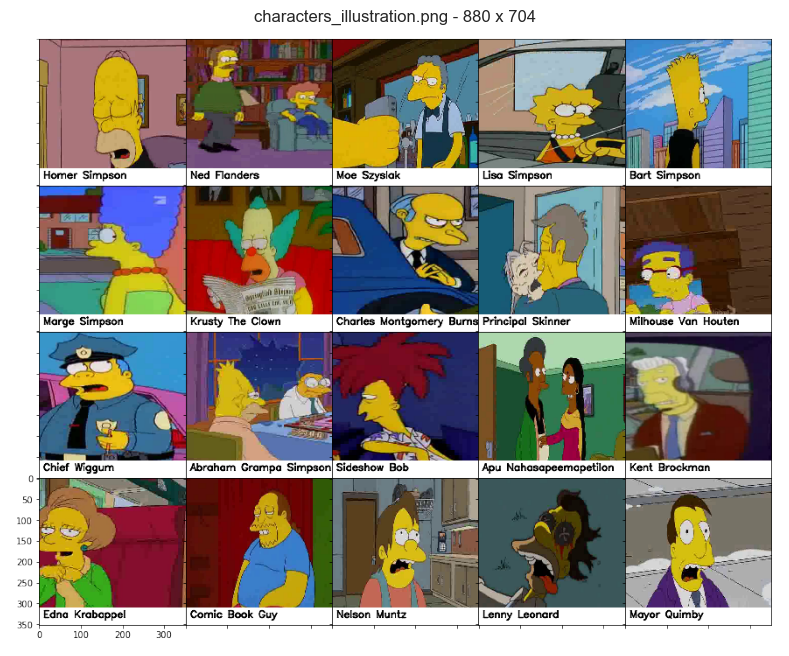

In [4]:
image = Image.open("./datasets/journey-springfield/characters_illustration.png")

plt.figure(figsize=(15, 8))
plt.imshow(image)
plt.title(get_image_info(image))
plt.axis('off')
plt.show()

In [5]:
TRAIN_DIR = Path('./datasets/journey-springfield/train/simpsons_dataset')

In [6]:
COUNT_PERSONS = {}

for person in TRAIN_DIR.iterdir():
    COUNT_PERSONS[str(person).split("\\")[-1]] = len(os.listdir(f'./{person}'))

COUNT_PERSONS = pd.Series(COUNT_PERSONS, name="sorted_data").sort_values()
COUNT_PERSONS

lionel_hutz                    3
disco_stu                      8
troy_mcclure                   8
miss_hoover                   17
fat_tony                      27
gil                           27
otto_mann                     32
sideshow_mel                  40
agnes_skinner                 42
rainier_wolfcastle            45
cletus_spuckler               47
snake_jailbird                55
professor_john_frink          65
martin_prince                 71
patty_bouvier                 72
ralph_wiggum                  89
carl_carlson                  98
selma_bouvier                103
barney_gumble                106
groundskeeper_willie         121
maggie_simpson               128
waylon_smithers              181
mayor_quimby                 246
lenny_leonard                310
nelson_muntz                 358
edna_krabappel               457
comic_book_guy               469
kent_brockman                498
apu_nahasapeemapetilon       623
sideshow_bob                 877
abraham_gr

In [7]:
def draw_sorted_data(data : pd.Series):
    plt.figure(figsize=(15, 9))
    sns.barplot(x=COUNT_PERSONS.index, y=COUNT_PERSONS, palette="Spectral", hue=COUNT_PERSONS.index).tick_params(axis='x', rotation=90)
    plt.title("Names of persons sorted by count")

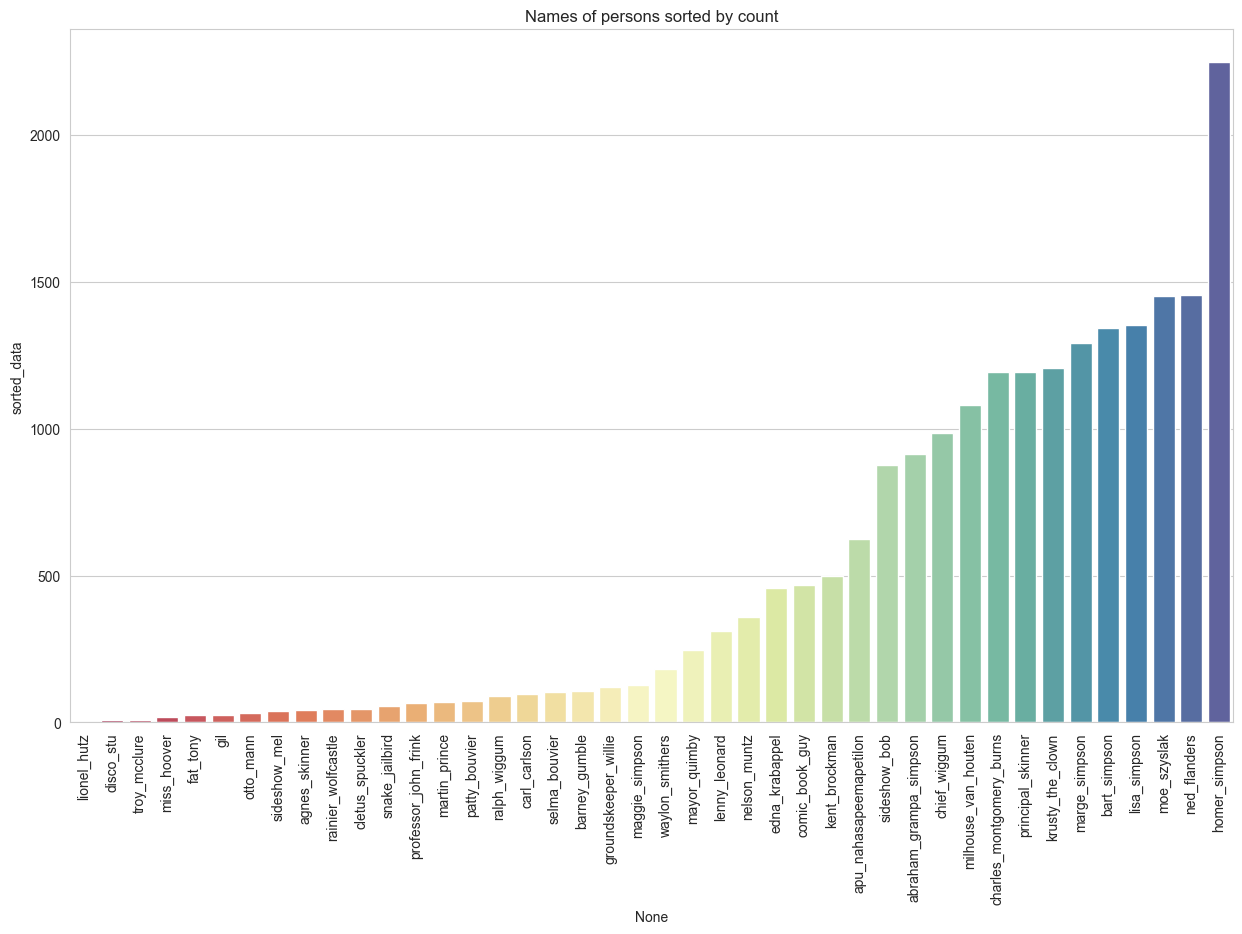

In [8]:
draw_sorted_data(COUNT_PERSONS)

In [9]:
DATA_MODES = ['train', 'val', 'test']

RESCALE_SIZE = 224

In [10]:
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomAutocontrast(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        transform_val = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        if self.mode == 'test':
            x = transform_test(x)  # Поменять transform только для test
        else:
            x = transform_val(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [11]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [12]:
TRAIN_DIR = Path('./datasets/journey-springfield/train')
TEST_DIR = Path('./datasets/journey-springfield/testset')

In [13]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [14]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

In [15]:
val_dataset = SimpsonsDataset(val_files, mode='val')

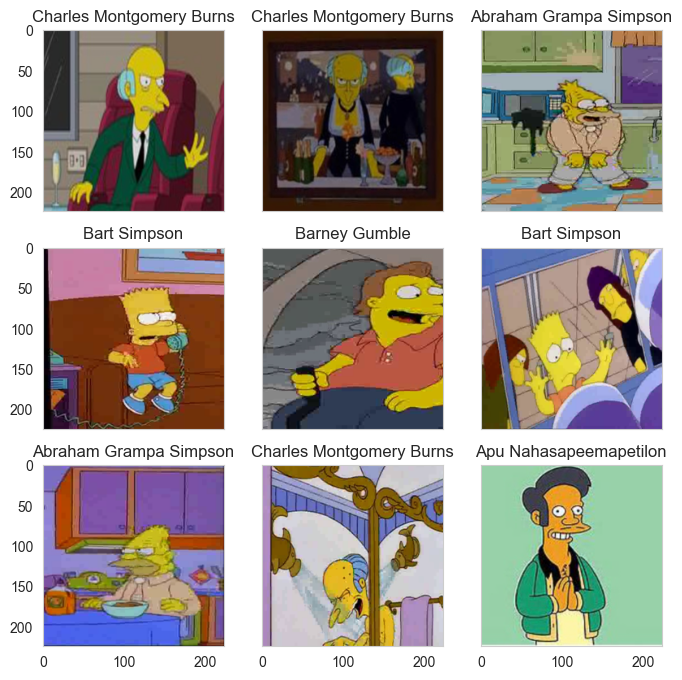

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)

In [17]:
class SimpleCnn(nn.Module): 

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [18]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [19]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [20]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [21]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [22]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

In [23]:
val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [25]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=128)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [27]:
history

[(2.6421669063936246,
  0.2712274667176253,
  2.04806693319059,
  tensor(0.4454, dtype=torch.float64)),
 (1.7434372820514912,
  0.5223262628192878,
  1.4920070118516011,
  tensor(0.6028, dtype=torch.float64)),
 (1.2255064893872945,
  0.6611886107395375,
  1.2177718277874001,
  tensor(0.6827, dtype=torch.float64)),
 (0.8607090713757756,
  0.7613223772214791,
  1.0167153907906339,
  tensor(0.7344, dtype=torch.float64)),
 (0.6376309315579979,
  0.8208803108478248,
  0.9598474163657433,
  tensor(0.7606, dtype=torch.float64)),
 (0.4607804864977217,
  0.8654054398369323,
  0.9533688208051979,
  tensor(0.7730, dtype=torch.float64)),
 (0.32709858013008863,
  0.9033059430536977,
  1.023287754182739,
  tensor(0.7810, dtype=torch.float64)),
 (0.242124193092958,
  0.9278297980763106,
  1.0441999192177724,
  tensor(0.7906, dtype=torch.float64)),
 (0.17947173337092315,
  0.9460475189502516,
  1.1332578575242145,
  tensor(0.7709, dtype=torch.float64)),
 (0.13456480504619944,
  0.9595515637938722,
  1

In [28]:
def predict_one_sample(model, inputs):
    """Предсказание, для одной картинки"""
    with torch.no_grad():

        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [29]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [30]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [31]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [32]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [33]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 0.7


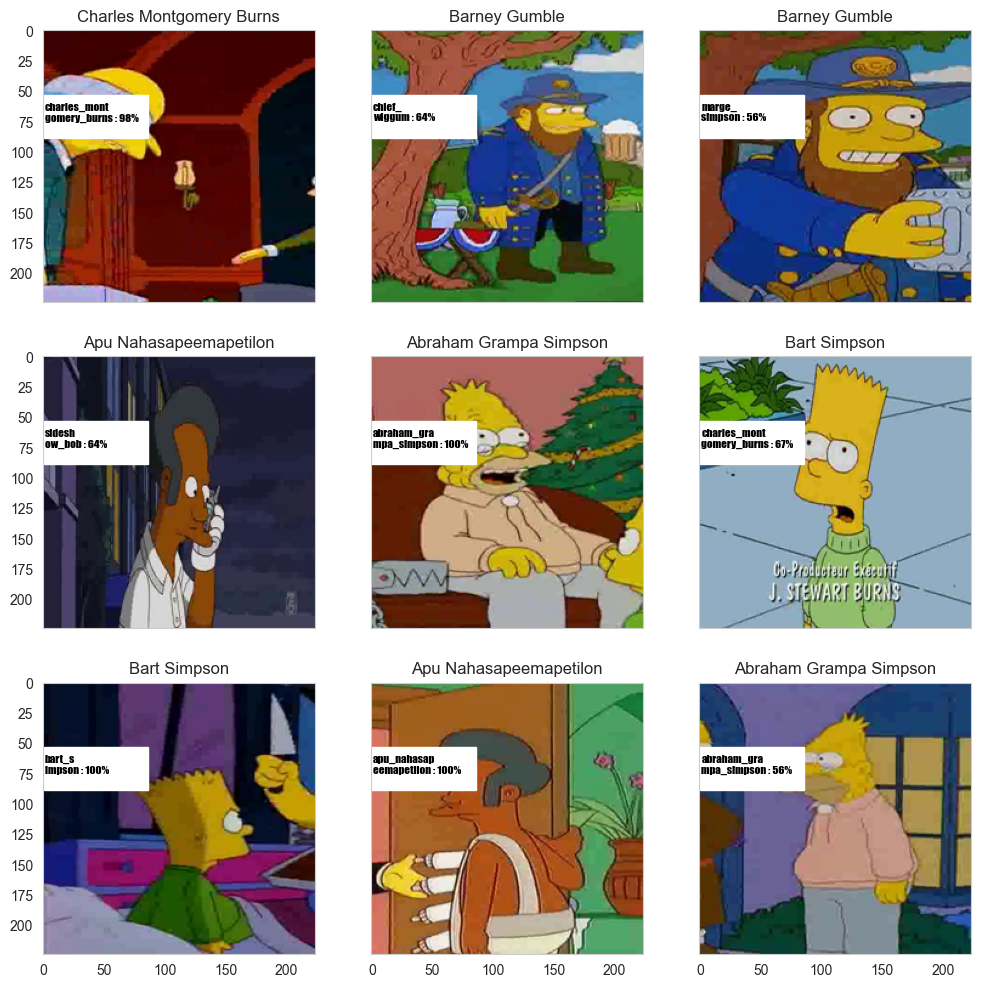

In [34]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [35]:
class SimpleCnnBatchNormed(nn.Module): 

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [36]:
n_classes = len(np.unique(train_val_labels))
simple_cnn_batch_normed = SimpleCnn(n_classes)
print("we will classify :{}".format(n_classes))
print(simple_cnn_batch_normed)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

In [37]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [47]:
history = train(train_dataset, val_dataset, model=simple_cnn_batch_normed, epochs=17, batch_size=64)

epoch:   0%|          | 0/17 [00:00<?, ?it/s]

TypeError: Unexpected type <class 'numpy.ndarray'>

In [ ]:
from torchvision import models

model_alexnet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

In [ ]:
model_alexnet

In [ ]:
for param in model_alexnet.features.parameters():
    param.requires_grad = False

In [ ]:
num_features = 4096

model_alexnet.classifier[6] = nn.Linear(num_features, n_classes)

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=model_alexnet, epochs=23, batch_size=64)

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_alexnet, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_alexnet, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

In [25]:
from torchvision import models

model_resnet = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)

for param in model_resnet.parameters():
    param.require_grad = False

num_features = model_resnet.fc.in_features
model_resnet.classifier = nn.Linear(num_features, n_classes)

if torch.cuda.is_available():
    model_resnet = model_resnet.cuda()
    print('Training with cuda')

model_resnet.classifier

Linear(in_features=2048, out_features=42, bias=True)

In [ ]:
history = train(train_files, val_files, model_resnet, 17, batch_size=32)

epoch:   0%|          | 0/17 [00:00<?, ?it/s]